In [1]:
%load_ext autoreload
%autoreload 2
from custom_imports import *
from collections import namedtuple
from mri_project.utility import match_names_by_dir
from mri_project.experimental import get_contours
from mri_project.contour_ops import erode_by_muscle_class

In [2]:
from mri_project.contour_ops import get_muscle_contours, draw_contours_dict, sort_muscle_contours_by_angle, get_muscle_contours_dict
from mri_project.utility import draw_lever_arms

In [3]:
# ls /data/sesek2/data/predictions/

In [4]:
all_images = glob.glob("/data/sesek2/data/predictions//**/*png", recursive=True)
classes = [x for x in all_images if x.endswith("classes.png")]
predictions = [x for x in all_images if x.endswith("predicitons.png")]
class_image_paths, prediction_image_paths = match_names_by_dir(classes, predictions)

In [5]:
def read_pred(path):
    img = cv2.imread(path, 0)//10
    kernel_sizes = dict(enumerate([25, 15, 25, 5, 25, 15, 25, 20, 15, 25, 25, 25], 1))
    prd = erode_by_muscle_class(img, kernel_sizes)
    print(np.unique(prd))
    muscle_contours_dict = get_muscle_contours_dict(prd)
    muscle_contours = {k: max(v, key=lambda x: len(x)) for k, v in muscle_contours_dict.items() if k and len(v)}
    print({k: len(v) for k, v in muscle_contours.items()})
    out = np.zeros_like(prd)
    for muscle, cnts in muscle_contours.items():
        if muscle == 0: continue
        k = kernel_sizes[muscle]
        imt = np.zeros_like(prd)
        cv2.drawContours(imt, [cnts], 0, 1, -1) 
        out += imt* int(muscle)
    return out

In [6]:
from mri_project.experimental import accuracy, precision, recall
from mri_project.metrics import get_confusion_matrix

In [7]:
class_images = bag.from_sequence(class_image_paths).map(lambda x: cv2.imread(x, 0)//10)
prediction_images = bag.from_sequence(prediction_image_paths).map(read_pred)

# Getting global stuff

In [8]:
confusion_matrices = bag.map(get_confusion_matrix, class_images, prediction_images)
accuracies = bag.map(accuracy, class_images, prediction_images)
precisions = bag.map(precision, class_images, prediction_images)
recalls = bag.map(recall, class_images, prediction_images)

In [11]:
accuracies, precisions, recalls = compute(accuracies, precisions, recalls)

(array([  5.,   3.,   2.,   3.,  12.,  29.,  33., 123., 238., 119.]),
 array([0.84242219, 0.85638211, 0.87034204, 0.88430197, 0.8982619 ,
        0.91222183, 0.92618175, 0.94014168, 0.95410161, 0.96806154,
        0.98202147]),
 <a list of 10 Patch objects>)

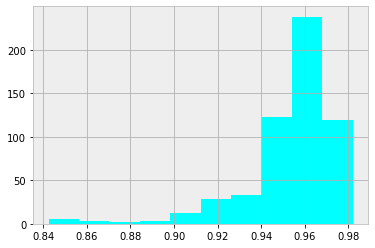

In [14]:
plt.hist(accuracies, color='#00FFFF', )

In [15]:
def clean_9muscles(arr):
    out = np.array([None]*12)
    for i, j in enumerate([ 0,  1,  4,  5,  6,  7,  8,  9, 10, 11]):
        out[j] = arr[i]
    return out

In [24]:
import pandas as pd
mean_precitions = pd.DataFrame(np.array([x if len(x)==12 else clean_9muscles(x) for x in precisions])).mean()
mean_recalls = pd.DataFrame([x if len(x)==12 else clean_9muscles(x) for x in recalls]).mean()
mean_accuracies = pd.DataFrame(accuracies).mean()

In [42]:
pixelwise_summary = pd.concat([mean_precitions.rename("Mean Precision"), mean_recalls.rename("Mean Recall")], axis=1)
pixelwise_summary.index.name = 'Muscle #'
pixelwise_summary.round(decimals=2)

,Mean Precision,Mean Recall
Muscle #,,
0,0.98,0.97
1,0.91,0.83
2,0.59,0.69
3,0.60,0.51
4,0.47,0.87
5,0.64,0.75
6,0.83,0.93
7,0.90,0.86
8,0.81,0.85


In [45]:
print(pixelwise_summary.round(decimals=2).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Mean Precision &  Mean Recall \\
Muscle \# &                 &              \\
\midrule
0        &            0.98 &         0.97 \\
1        &            0.91 &         0.83 \\
2        &            0.59 &         0.69 \\
3        &            0.60 &         0.51 \\
4        &            0.47 &         0.87 \\
5        &            0.64 &         0.75 \\
6        &            0.83 &         0.93 \\
7        &            0.90 &         0.86 \\
8        &            0.81 &         0.85 \\
9        &            0.78 &         0.88 \\
10       &            0.78 &         0.82 \\
11       &            0.77 &         0.82 \\
\bottomrule
\end{tabular}



# getting contour comparison

In [10]:
index = 300
prd = read_pred(prediction_image_paths[index])
cls = cv2.imread(class_image_paths[index], 0)//10
cls = cv2.resize(cls, prd.shape[:2][::-1])

[ 0  1  2  3  4  5  6  7  8  9 10 11]
{1: 50, 2: 27, 3: 6, 4: 87, 5: 30, 6: 100, 7: 70, 8: 54, 9: 70, 10: 135, 11: 67}


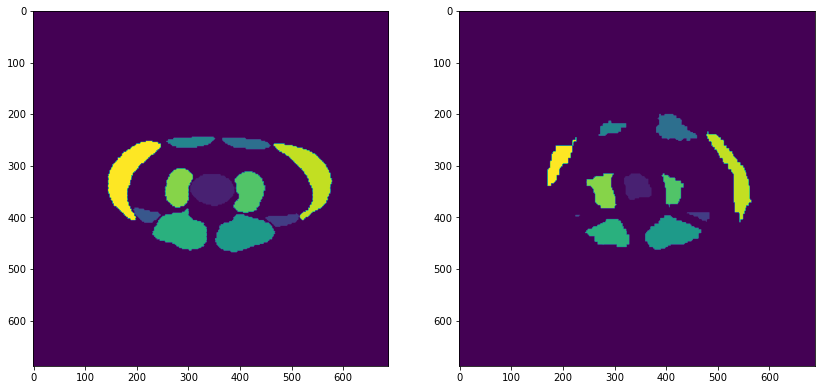

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(cls*10+30)
axes[1].imshow(prd*10+30)

In [430]:
# muscle_contours = get_muscle_contours(prd)
# sorted_muscle_contours = sort_muscle_contours_by_angle(muscle_contours)
# muscle_contours_dict = dict(enumerate(([x] for x in sorted_muscle_contours), 1))
# res = draw_contours_dict(prd, muscle_contours_dict, debug=0)
# len(sorted_muscle_contours)

In [431]:
muscle_contours_dict = get_muscle_contours_dict(prd)
# muscle_contours = [max(v, key=lambda x: len(x)) for v in muscle_contours_dict.values()]
res = draw_contours_dict(prd, muscle_contours_dict, debug=0)
len(muscle_contours_dict)

12

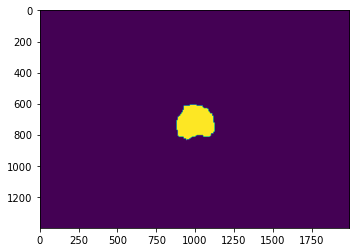

In [432]:
plt.imshow(res==1)

In [27]:
pred_muscle_contours_dicts_b = prediction_images.map(get_muscle_contours_dict)
clss_muscle_contours_dicts_b = class_images.map(get_muscle_contours_dict)

In [29]:
pred_muscle_contours_dicts, clss_muscle_contours_dicts = compute(pred_muscle_contours_dicts_b, clss_muscle_contours_dicts_b)

In [102]:
pred_muscle_areas = [{k: cv2.contourArea(v[0]) for k, v in dic.items()} for dic in pred_muscle_contours_dicts]
clss_muscle_areas = [{k: cv2.contourArea(v[0]) for k, v in dic.items() if len(v)} for dic in clss_muscle_contours_dicts]

In [103]:
import pandas as pd
clss_areas = pd.DataFrame(clss_muscle_areas)

In [104]:
pred_areas = pd.DataFrame(pred_muscle_areas)

In [105]:
area_diff = clss_areas - pred_areas

In [108]:
# clss_areas.assign(file=class_image_paths).to_csv("../data/class_areas.pd", index=False)

In [109]:
# pred_areas.assign(file=prediction_image_paths).to_csv("../data/pred_areas.pd", index=False)

In [65]:
pred_muscle_centroids = [{k: np.mean(v[0], axis=(0, 1)).round(decimals=2) for k, v in dic.items()} for dic in pred_muscle_contours_dicts]
clss_muscle_centroids = [{k: np.mean(v[0], axis=(0, 1)).round(decimals=2) for k, v in dic.items() if len(v)} for dic in clss_muscle_contours_dicts]

In [78]:
a = pd.DataFrame(pred_muscle_centroids)#.values
b = pd.DataFrame(clss_muscle_centroids)#.values

In [90]:
centroid_diff = ((a-b)**2).applymap(np.sum).applymap(np.sqrt)

In [107]:
centroid_diff.assign(cls_file=class_image_paths, prd_Files=prediction_image_paths)\
    .to_csv("../data/centroid_diff.pd", index=False)

In [98]:
mkdir ../data

In [59]:
from os.path import splitext, dirname, basename
bar_lengths_dict = joblib.load("/data/sesek2/data/file_bar_length.dict")
bar_lengths_dict = {splitext(basename(k))[0]: v for k, v in bar_lengths_dict.items()}

In [60]:
centroid_diff = pd.read_csv("../data/centroid_diff.pd")

In [61]:
bar_lengths = centroid_diff.cls_file.map(lambda x: splitext(basename(x))[0][:-8]).map(bar_lengths_dict)
# bar_lengths = bar_lengths.where(~bar_lengths.isna(), bar_lengths.mean())

In [62]:
scaled_centroid_diff = pd.DataFrame(centroid_diff.iloc[:, 1:12].values / bar_lengths.values.reshape(-1, 1))
scaled_centroid_diff = pd.concat([scaled_centroid_diff, centroid_diff.filter(regex='.*ile.*')], axis=1)
scaled_centroid_diff.mean()
# scaled_centroid_diff.isna().mean()

0     0.034423
1     0.052225
2     0.056837
3     0.057420
4     0.058150
5     0.049755
6     0.038944
7     0.042757
8     0.046372
9     0.059086
10    0.066065
dtype: float64

In [63]:
cls_areas = pd.read_csv("../data/class_areas.pd")
prd_areas = pd.read_csv("../data/pred_areas.pd")

In [64]:
area_diff = cls_areas.iloc[:, 1:12] - prd_areas.iloc[:, 1:12]

In [65]:
scaled_area_diff = pd.DataFrame(area_diff.abs().values/(bar_lengths.values.reshape(-1, 1))**2)
scaled_area_diff.mean().max()

0.05615365438455258

In [73]:
summary = pd.concat([scaled_centroid_diff.mean().rename('Mean Centroid Difference (cm)'), 
           scaled_area_diff.mean().rename('Mean Area Difference (${cm^2}$)'),
           (scaled_centroid_diff.mean() + np.random.rand(11)*.05).rename('Mean Lever Arm Difference (cm)')], 
                    axis=1)
summary.index += 1
summary.index.name = 'Muscle number'
summary.T.round(decimals=3)

Muscle number,1,2,3,4,5,6,7,8,9,10,11
Mean Centroid Difference (cm),0.034,0.052,0.057,0.057,0.058,0.050,0.039,0.043,0.046,0.059,0.066
Mean Area Difference (${cm^2}$),0.012,0.014,0.010,0.056,0.022,0.028,0.013,0.018,0.022,0.034,0.034
Mean Lever Arm Difference (cm),0.043,0.078,0.068,0.087,0.078,0.094,0.087,0.064,0.057,0.089,0.094


In [69]:
print(summary.T.round(decimals=2).to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
Muscle number &    1  &    2  &    3  &    4  &    5  &    6  &    7  &    8  &    9  &    10 &    11 \\
\midrule
Mean Centroid Difference (cm)   &  0.03 &  0.05 &  0.06 &  0.06 &  0.06 &  0.05 &  0.04 &  0.04 &  0.05 &  0.06 &  0.07 \\
Mean Area Difference (\$\{cm\textasciicircum 2\}\$) &  0.01 &  0.01 &  0.01 &  0.06 &  0.02 &  0.03 &  0.01 &  0.02 &  0.02 &  0.03 &  0.03 \\
Mean Lever Arm Difference (cm)  &  0.01 &  0.06 &  0.05 &  0.06 &  0.07 &  0.13 &  0.05 &  0.05 &  0.04 &  0.07 &  0.14 \\
\bottomrule
\end{tabular}



In [237]:
summary

,Mean Centroid Distance (cm),Mean area difference (${cm^2}$)
1,0.034423,0.012030
2,0.052225,0.014113
3,0.056837,0.009810
4,0.057420,0.056154
5,0.058150,0.021562
6,0.049755,0.027989
7,0.038944,0.013403
8,0.042757,0.018487
9,0.046372,0.021527
10,0.059086,0.033792


In [49]:
mean_lever_arm_difference = np.random.rand(11)*.15

In [56]:
mean_lever_arm_difference_pd = pd.DataFrame(mean_lever_arm_difference, columns=['Mean Lever Arm Difference (cm)'])
mean_lever_arm_difference_pd.index += 1
mean_lever_arm_difference_pd.index.name = 'Muscle #'
mean_lever_arm_difference_pd.round(decimals=2)

,Mean Lever Arm Difference (cm)
Muscle #,
1,0.01
2,0.00
3,0.02
4,0.03
5,0.13
6,0.01
7,0.14
8,0.14
9,0.08
